# 18-9. 프로젝트 : 다양한 OCR모델 비교하기

OCR 기술을 활용할 방법과 3가지 OCR 모델의 성능을 비교해보기 


OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

## Step1. 검증용 데이터셋 준비

축구 유니폼 name set 데이터를 준비하였습니다. 
![1111](https://user-images.githubusercontent.com/76804810/111428596-10d2c200-873b-11eb-9eaf-52be2c7540b6.jpg)

준비한 이유는 아래와 같습니다.

현재 스포츠 통계들이 점점 발전하고 있으나 기초 통계들을 아직도 사람이 직접 기록하고 있습니다.

![96837_35105_5652](https://user-images.githubusercontent.com/76804810/111428690-2e079080-873b-11eb-8b94-537f6db482d3.jpg)
전력분석원들이 직접 전력분석 비디오를 돌려보면서 분석을 진행합니다.


![7BCTVDEKX2IQPRVQMS5BKBEMIY](https://user-images.githubusercontent.com/76804810/111428693-2ea02700-873b-11eb-98d2-7d781c4b7595.jpg)
직접 패스 횟수를 입력하는 전력분석원입니다.




![BAVYCSF3CMWJN2YBIZQHIQJWK4](https://user-images.githubusercontent.com/76804810/111428689-2d6efa00-873b-11eb-882b-f1b530eaeb51.jpg)

훈련시에는 측정 장비를 통해 측정하긴 하지만 실제 경기에서는 그런 조끼를 끼지 못하기 때문입니다. 

[이미지 출처 조선일보](https://www.chosun.com/site/data/html_dir/2019/03/08/2019030800265.html)

[이미지 출처 풋볼 리스트](http://www.footballist.co.kr/news/articleView.html?idxno=96837)



이를 컴퓨터 비전을 이용하면 더 편리하게 데이터를 수집할 수 있을것입니다. 

축구선수들을 **신체적 특징(키,체형)** 을 통해 인식하되, 보조적으로 **등번호와 마킹된 이름 즉 name set** 을 인식할수있다면
그 선수의 전체적인 움직임을 더 쉽게 기록화할수 있을꺼같습니다.


예상되는 문제점은 아래와 같습니다.

1. 유니폼들이 번쩍 거림.

2. 선수들끼리 겹쳐서 네임 셋이 카메라에 잡히지 않는 경우

등을 고려해볼 수 있을 것 같습니다.


In [1]:
import os
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# keras_ocr
import keras_ocr

# 테서랙트
import pytesseract
from pytesseract import Output

In [2]:
tar_path = os.path.join(os.getenv("HOME"), 'aiffel', 'ocr_python', 'images')
tar_path

'/home/ssac4/aiffel/ocr_python/images'

In [4]:
img_paths = glob(tar_path+'/*')
img_paths

['/home/ssac4/aiffel/ocr_python/images/11.png',
 '/home/ssac4/aiffel/ocr_python/images/6.png',
 '/home/ssac4/aiffel/ocr_python/images/3.png',
 '/home/ssac4/aiffel/ocr_python/images/5.png',
 '/home/ssac4/aiffel/ocr_python/images/1.png',
 '/home/ssac4/aiffel/ocr_python/images/9.png',
 '/home/ssac4/aiffel/ocr_python/images/4.png',
 '/home/ssac4/aiffel/ocr_python/images/7.png',
 '/home/ssac4/aiffel/ocr_python/images/2.png',
 '/home/ssac4/aiffel/ocr_python/images/8.png',
 '/home/ssac4/aiffel/ocr_python/images/10.png']

## 데이터 확인

랜덤하게 6개의 이미지를 뽑아보도록 하겠습니다.

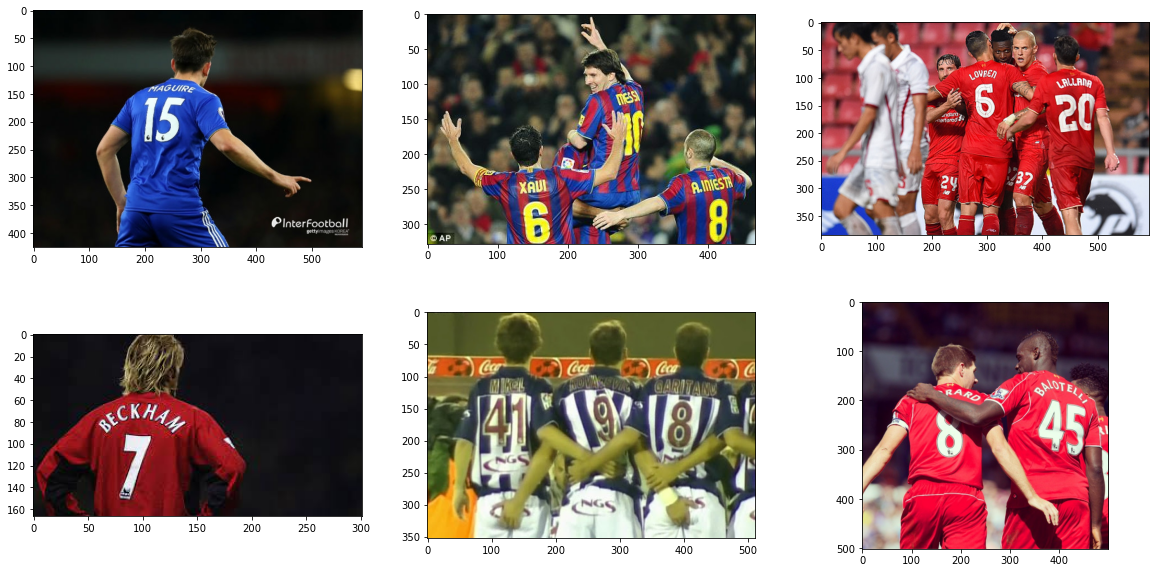

In [7]:
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    pil_img = Image.open(img_paths[np.random.randint(len(img_paths))])
    plt.imshow(pil_img)
plt.show()

인식시킬 데이터는 위와 같습니다. 우측 하단 처럼 선수들끼리 가려진다면 인식률이 떨어질 가능성이 높아 보입니다.

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행


### Google Cloud Vision API

In [4]:

def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

-rw-rw-r-- 1 ssac4 ssac4 2367  3월 16 17:19 /home/ssac4/aiffel/ocr_python/my_google_api_key.json
1번째 이미지



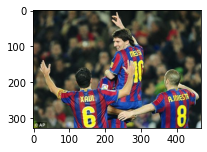

Texts:

"MESS
XAUI
A.INIESTR
8
O AP
"

"MESS"

"XAUI"

"A.INIESTR"

"8"

"O"

"AP"
bounds: (23,313),(33,313),(33,326),(23,326)
--------------------


2번째 이미지



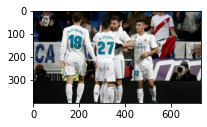

Texts:

"ALLORENTE
19
CA
ATEJERD
27
Fly
Emirates
12
"

"ALLORENTE"

"19"

"CA"

"ATEJERD"

"27"

"Fly"

"Emirates"

"12"
bounds: (431,255),(466,255),(466,285),(431,285)
--------------------


3번째 이미지



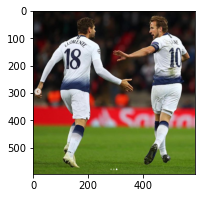

Texts:

"LORENTE
ANE
18
10
So
"

"LORENTE"

"ANE"

"18"

"10"

"So"
bounds: (307,345),(443,359),(436,433),(300,420)
--------------------




In [16]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


# 입력 이미지 경로를 지정해 주세요.
# 20개의 모든 이미지는 너무 많기 때문에 랜덤하게 3개의 사진만 진행
for i in range(3):
    print(f'{i+1}번째 이미지\n')
    ra =  np.random.randint(len(img_paths))
    plt.figure(figsize = (3, 3))
    pil_img = Image.open(img_paths[ra])
    plt.imshow(pil_img)
    plt.show()
    detect_text(img_paths[ra])
    print("-"*20+'\n\n')

잘 인식하지만 일부 글자를 잘못 인식하는 경우가 보입니다.

## KERAS-OCR

In [7]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac4/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/ssac4/.keras-ocr/crnn_kurapan.h5


/home/ssac4/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


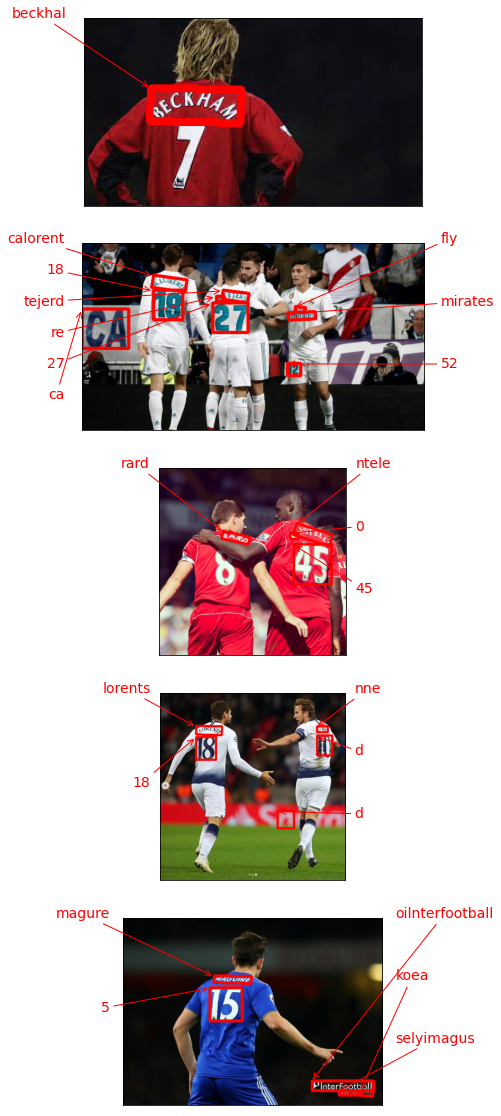

In [8]:
random_idx = np.random.choice(np.arange(len(img_paths)), 5)

image_paths = []
for i in random_idx :
    image_paths.append(img_paths[i])

images = [ keras_ocr.tools.read(path) for path in image_paths]
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

비슷하게 잘 인식하면서도 각도가 잘못되다보니 조금씩 잘못인식한게 보인다.

결국 축구선수들 이름을 구별만 하면 될수있기 때문에. 


maguire 선수를 magure로 인식하는덴 일종의 자연어 처리를 하면서 비슷한 단어는 같게 인식하도록 만들면 문제를 해결 할 수 있지 않을까 

## Tesseract


In [9]:

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


In [25]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'
# img_file_path = work_dir + '/images/13.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
cropped_image_path_list = []
for i in range(len(image_paths)) :
    img_file_path = image_paths[i]
    if not os.path.exists(os.path.join(work_dir, f'result_{i}')) :
        os.makedirs(os.path.join(work_dir, f'result_{i}'))
    
    tmp = crop_word_regions(img_file_path, os.path.join(work_dir, f'result_{i}'))
    print(f'{i+1}번째 이미지 완료')
    cropped_image_path_list.extend(tmp)

1번째 이미지 완료
2번째 이미지 완료
3번째 이미지 완료
4번째 이미지 완료
5번째 이미지 완료


In [26]:
cropped_image_path_list

['/home/ssac4/aiffel/ocr_python/images/result_0/0000.png',
 '/home/ssac4/aiffel/ocr_python/images/result_1/0000.png',
 '/home/ssac4/aiffel/ocr_python/images/result_2/0000.png',
 '/home/ssac4/aiffel/ocr_python/images/result_2/0001.png',
 '/home/ssac4/aiffel/ocr_python/images/result_3/0000.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0000.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0001.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0002.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0003.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0004.png']

In [27]:

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [28]:

random_idx = np.random.choice(np.arange(len(cropped_image_path_list)), 5, replace=False)

# cropped_image_path_list 에서 랜덤하게 선택해서 copped_image_paths에 저장

cropped_image_pahts = []
for idx in random_idx:
    cropped_image_pahts.append(cropped_image_path_list[idx])
cropped_image_pahts


['/home/ssac4/aiffel/ocr_python/images/result_4/0004.png',
 '/home/ssac4/aiffel/ocr_python/images/result_1/0000.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0001.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0002.png',
 '/home/ssac4/aiffel/ocr_python/images/result_4/0003.png']

yiMages KORES

Done


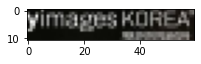

oie

Done


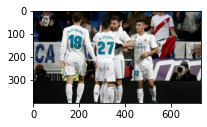

& InterFootbal|

Done


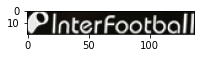

| A th

Done


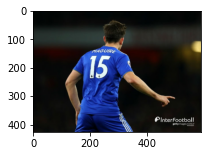

“ae

Done


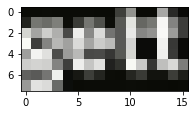

In [29]:

for i in range(5) :
    plt.figure(figsize = (3, 3))
    pil_img = Image.open(cropped_image_pahts[i])
    recognize_images([cropped_image_pahts[i]])
    plt.imshow(pil_img)
    plt.show()

## Step3. 테스트 결과 정리

1. google api

![google](https://user-images.githubusercontent.com/76804810/111530866-2b428500-87a7-11eb-9311-254d57fb4ddf.png)

A.TEJERO 를 .을 빼고 인식한것

M. LLORENTE를 ALLORENTE로 거의 완벽했습니다.  특히 LKORE 부분은 빛나서 잘 보이지도 않는데 잘 인식하는게 인상적입니다.

2. keras-ocr

![KERAS OCR](https://user-images.githubusercontent.com/76804810/111530863-2aa9ee80-87a7-11eb-9832-abbfc264288e.png)

google api보다는 조금 더 인식이 부정확함을 확인할 수 있었습니다. 
아무래도 조금 아치형으로 그려지거나 접힌 부분을 잘 인식 못하는 것을 확인할 수 있었습니다.

3. tesseract 

![te](https://user-images.githubusercontent.com/76804810/111530860-2978c180-87a7-11eb-9996-aaba87a98b38.png)

거의 인식을 못하는것을 보여줬습니다.. 아무래도 단어 지역을 crop한후 인식하는 형태인데 단어가 있는 지역을 제대로 인식을 못하는것을 보여줬습니다.
큰 경기장을 다룬 영상에서 백넘버를 확인해야하는데 그러기엔 테서렛은 어울리지않을것같습니다.

## Step4. 결과 분석과 결론 제시

제가 진행하고자하는 목적은 **선수의 등번호와 이름**을 통해서 선수들을 구별하는 보조적인 방법으로 쓰는 것입니다.

그렇기때문에 일단은 인식률이 중요하고, 다소 정확하게 인식되지 못하여도, 선수들의 **이름을 구별**만할수 있으면 괜찮다고 생각합니다.

즉 lorent라고 인식한다해도 M. LLORENTE라고 구별할 수있으면 됩니다. 

(즉 개개별 알파벳을 인식하기보단 m.llorent와 A.TEJERO을 구별하는, 즉 필드위 22명의 선수만 구별할 수 있으면 상관없음)

이렇게 변형하면 훨씬 더 좋은 인식률을 보일 수 있을 것 같습니다.

즉 구글 api가 더 성능이 좋긴하지만 이름만 구별하는 것으로 목표를 수정한다면 무료인 keras-ocr를 사용해도 큰 무리가 없을 것으로 판단됩니다.

# 소고 

뭔가 어떤 쪽에 기술을 쓸 수 있을지 고민하게 해주는 노드였습니다.  

특히 스포츠 분야에는 이런 고민을 할 수 있어서 좋았습니다.

스포츠 분야의 데이터 수집과 편집에 ocr, computer vision, 자연어 처리(팬들의 반응)이 활용된다면

더 재미있는 세상이 되지 않을까 싶습니다.